# DBSCAN 聚类算法
本质是在寻找数据集的中心点，然后根据中心点将数据分为若干个簇，每个簇的中心点就是簇的中心。
1. 随机选择一个点作为初始中心点，并以此为圆心划定一个范围
2. 根据该圆内所有数据点的均值，计算该圆内的质心,并作为新的圆心
3. 重复步骤2，直到中心点不再变化
这种方式可以减少数据集的维度，但需要设置合适的半径，否则可能会造成数据点聚集。

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 设置中文显示
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 机器学习相关
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

# 一、数据预处理
### 1 加载数据集

In [8]:
f1 = '../../data/周一所获数据/所有学员的学习总时长ms.csv'
f2 = '../../data/周一所获数据/所有学员的OPENID使用情况.csv'
f3 = '../../data/周一所获数据/所有学员的IP使用情况.csv'

df_duration = pd.read_csv(f1, dtype={'trainingPersonId': 'string', 'totalDuration': 'float64'})
df_openid = pd.read_csv(f2, dtype={'openIdCount': 'int64', 'openIds': 'string'})
df_ip = pd.read_csv(f3, dtype={'_id': 'string', 'ipCount': 'int'})

### 2 合并单个大特征表

In [9]:
df_intermedia_1 = pd.merge(df_duration, df_openid, left_on='trainingPersonId', right_on='_id', how='inner')
df_intermedia_2 = pd.merge(df_intermedia_1, df_ip, left_on='_id', right_on='_id', how='inner')

In [10]:
df_final = df_intermedia_2[["_id", "openIdCount", "ipCount", "totalDuration"]]
df_final[["totalDuration"]] = df_final[["totalDuration"]] / 1000 / 60 / 60  # 转换为小时

C:\Users\fjhb\AppData\Local\Temp\ipykernel_21888\4045145170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[["totalDuration"]] = df_final[["totalDuration"]] / 1000 / 60 / 60  # 转换为小时


In [11]:
# df_final.to_csv("./3-features.csv", index=False)

In [12]:
# 数据归一化
scaler = MinMaxScaler()
train_x = scaler.fit_transform(df_final.drop("_id", axis=1))

---

# 二、机器学习
### 1 DBSCAN 聚类
1. `eps` 邻域半径:指点与点之间的最大距离，可以被视为一个点邻域的物理尺寸。选择较小的 `eps` 值可能导致聚类过于分散，而过大的 `eps` 值可能将本不属于同一类的点强行聚合在一起
2. `minPts` 最小点数:定义了一个点的邻域中需要有多少个点才能将其视为核心点。`minPts` 的选择与数据的维度、密度和噪声水平密切相关。一般来说，更高的维度和噪声水平需要更大的 `minPts` 值。
3. `labels_` 聚类标签:会为每个发现的聚类分配一个唯一的正整数(1,2,...)作为标签;`-1`表示噪声点.注意标签值顺序没特殊意义

In [52]:
classifier = DBSCAN(eps=0.15, min_samples=5000)
classifier.fit(train_x)

labels = classifier.labels_

In [53]:
n_clusters_ = len(set(labels)) -(1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

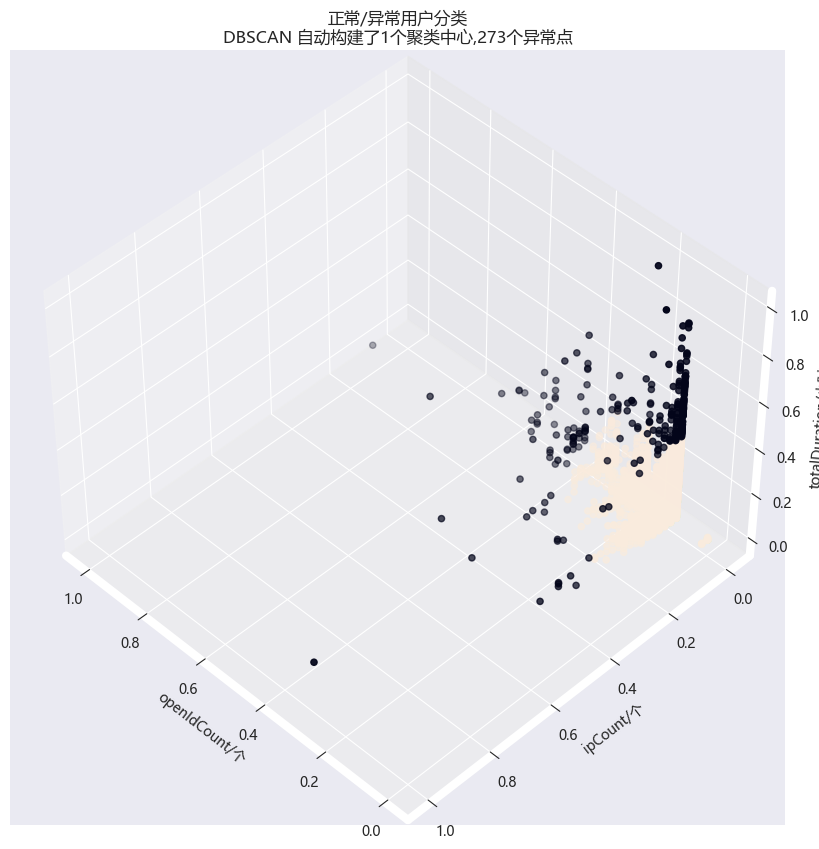

In [58]:
plt.rcParams['axes.linewidth'] = 6
fig = plt.figure(figsize=(10, 20))

ax = fig.add_subplot(projection="3d", elev=45, azim=135)

ax.set_xlabel("openIdCount/个")
ax.set_ylabel("ipCount/个")
ax.set_zlabel("totalDuration/小时")

ax.scatter(train_x[:, 0], train_x[:, 1], train_x[:, 2], c=labels)
# ax.scatter(centers[0,:], centers[1,:])

plt.title(f"正常/异常用户分类\nDBSCAN 自动构建了{n_clusters_}个聚类中心,{n_noise_}个异常点")

# plt.savefig("./imgs/DBSCAN-3-features(归一化).png")
plt.show()
